| Credentials |                                  |
|----|----------------------------------|
|Host | Montanuniversitaet Leoben        |
|Web | https://cps.unileoben.ac.at      |
|Mail | cps@unileoben.ac.at              |
|Author | Fotios Lygerakis                 |
|Corresponding Authors | fotios.lygerakis@unileoben.ac.at |
|Last edited | 28.09.2023                       |

In the first part of this tutorial we will build a fully connected MLP Autoencoder on the MNIST dataset. Then we will perform linear probing on the encoder features to see how well they perform on a linear classification task.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import adjusted_rand_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from tqdm import tqdm

Set random seed

In [2]:
# Set random seed
torch.manual_seed(0)

Load the MNIST dataset

In [3]:
# Define the transformations
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
# Download and load the test data
testset = datasets.MNIST('data', download=True, train=False, transform=transform)


Print some examples from the dataset

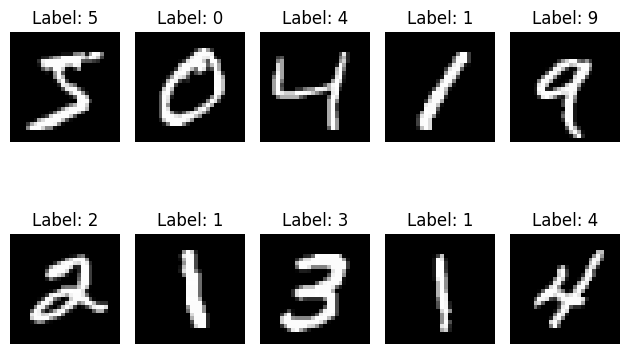

In [4]:
# Get the first 10 samples
dataiter = iter(trainset)
images, labels = [], []

for i in range(10):
    image, label = next(dataiter)
    images.append(image)
    labels.append(label)

# Plot the samples
fig, axes = plt.subplots(2, 5)

for ax, img, lbl in zip(axes.ravel(), images, labels):
    ax.imshow(img.squeeze().numpy(), cmap='gray')
    ax.set_title(f'Label: {lbl}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Define the MLP and Convolutional Autoencoder

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, type='mlp'):
        super(Autoencoder, self).__init__()
        # type of autoencoder
        self.type = type
        if self.type == 'mlp':
            self.encoder = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.ReLU(True))
            self.decoder = nn.Sequential(
                nn.Linear(hidden_size, input_size),
                nn.ReLU(True),
                nn.Sigmoid()
            )
        elif self.type == 'cnn':
            # Encoder module
            self.encoder = nn.Sequential(
                nn.Conv2d(in_channels=input_size, out_channels=hidden_size//2, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=hidden_size//2, out_channels=hidden_size, kernel_size=3, stride=2, padding=1),
                nn.ReLU()
            )
            # Decoder module
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(in_channels=hidden_size, out_channels=hidden_size//2, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(in_channels=hidden_size//2, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Sigmoid()  # Sigmoid to ensure the output is between 0 and 1
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Check if GPU support is available

In [6]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Define the training function

In [7]:
# Define the training function
def train(model, train_loader, optimizer, criterion, epoch, verbose=True):
    model.train()
    train_loss = 0
    for i, (data, _) in enumerate(train_loader):
        # check the type of autoencoder and modify the input data accordingly
        if model.type == 'mlp':
            data = data.view(data.size(0), -1)
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= len(train_loader.dataset)
    if verbose:
        print(f'{model.type}====> Epoch: {epoch} Average loss: {train_loss:.4f}')   
    return train_loss

The evaluation functions for the linear classification and clustering tasks

In [8]:
# Extract encoded representations for a given loader
def extract_features(loader, model):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for data in loader:
            img, label = data
            if model.type == 'mlp':
                img = img.view(img.size(0), -1)
            img = img.to(device)
            feature = model.encoder(img)
            if model.type == 'cnn':
                feature = feature.view(feature.size(0), -1)  # Flatten the CNN encoded features
            features.append(feature)
            labels.append(label)
    return torch.cat(features), torch.cat(labels)

# Define the loss test function
def test_loss(model, test_loader, criterion):
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            # check the type of autoencoder and modify the input data accordingly
            if model.type == 'mlp':
                data = data.view(data.size(0), -1)
            data = data.to(device)
            output = model(data)
            eval_loss += criterion(output, data).item()
    eval_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(eval_loss))
    return eval_loss

# Define the linear classification test function
def test_linear(encoded_train, train_labels, encoded_test, test_labels):
    train_features_np = encoded_train.cpu().numpy()
    train_labels_np = train_labels.cpu().numpy()
    test_features_np = encoded_test.cpu().numpy()
    test_labels_np = test_labels.cpu().numpy()
    
    # Apply logistic regression on train features and labels
    logistic_regression = LogisticRegression(random_state=0, max_iter=100).fit(train_features_np, train_labels_np)
    print(f"Train accuracy: {logistic_regression.score(train_features_np, train_labels_np)}")
    # Apply logistic regression on test features and labels
    test_accuracy = logistic_regression.score(test_features_np, test_labels_np)
    print(f"Test accuracy: {test_accuracy}")
    return test_accuracy


def test_clustering(encoded_features, true_labels):
    encoded_features_np = encoded_features.cpu().numpy()
    true_labels_np = true_labels.cpu().numpy()
    
    # Apply k-means clustering
    kmeans = KMeans(n_clusters=10, n_init=10, random_state=0).fit(encoded_features_np)
    cluster_labels = kmeans.labels_
    
    # Evaluate clustering results using Adjusted Rand Index
    ari_score = adjusted_rand_score(true_labels_np, cluster_labels)
    print(f"Clustering ARI score: {ari_score}")
    return ari_score

def knn_classifier(encoded_train, train_labels, encoded_test, test_labels, k=5):
    encoded_train_np = encoded_train.cpu().numpy()
    encoded_test_np = encoded_test.cpu().numpy()
    train_labels_np = train_labels.cpu().numpy()
    test_labels_np = test_labels.cpu().numpy()
    
    # Apply k-nearest neighbors classification
    knn = KNeighborsClassifier(n_neighbors=k).fit(encoded_train_np, train_labels_np)
    accuracy_score = knn.score(encoded_test_np, test_labels_np)
    print(f"KNN accuracy: {accuracy_score}")
    return accuracy_score

def test(model, train_loader, test_loader, criterion):
    # Extract features once for all tests
    encoded_train, train_labels = extract_features(train_loader, model)
    encoded_test, test_labels = extract_features(test_loader, model)
    print(f"{model.type} Autoencoder")
    results = {
        'reconstruction_loss': test_loss(model, test_loader, criterion),
        'linear_classification_accuracy': test_linear(encoded_train, train_labels, encoded_test, test_labels),
        'knn_classification_accuracy': knn_classifier(encoded_train, train_labels, encoded_test, test_labels),
        'clustering_ari_score': test_clustering(encoded_test, test_labels)
    }
    
    # Save results to a log file
    with open("evaluation_results.log", "w") as log_file:
        for key, value in results.items():
            log_file.write(f"{key}: {value}")
            
    return results


In [9]:
# Define the training parameters for the fully connected MLP Autoencoder
batch_size = 32
epochs = 5
hidden_size = 128
train_frequency = epochs
test_frequency = epochs

# Create the fully connected MLP Autoencoder
input_size = trainset.data.shape[1] * trainset.data.shape[2]
ae = Autoencoder(input_size, hidden_size, type='mlp').to(device)
input_size=1
cnn_ae = Autoencoder(input_size, hidden_size, type='cnn').to(device)
# print the models' number of parameters
print(f"MLP AE parameters: {sum(p.numel() for p in ae.parameters())}")
print(f"CNN AE parameters: {sum(p.numel() for p in cnn_ae.parameters())}")

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
optimizer_cnn = optim.Adam(cnn_ae.parameters(), lr=1e-3)


MLP AE parameters: 201616
CNN AE parameters: 148865


In [10]:
# Create the train and test dataloaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [11]:
test_mlp = []
test_cnn = []
# Train the model
for epoch in tqdm(range(1, epochs + 1)):
    verbose = True if epoch % train_frequency == 0 else False
    train(ae, train_loader, optimizer, criterion, epoch, verbose)
    train(cnn_ae, train_loader, optimizer_cnn, criterion, epoch, verbose)

    # test every n epochs
    if epoch % test_frequency == 0:
        restults_dic = test(ae, train_loader, test_loader, criterion)
        test_mlp.append([restults_dic['reconstruction_loss'], restults_dic['linear_classification_accuracy'], restults_dic['knn_classification_accuracy'], restults_dic['clustering_ari_score']])
        restults_dic = test(cnn_ae, train_loader, test_loader, criterion)
        test_cnn.append([restults_dic['reconstruction_loss'], restults_dic['linear_classification_accuracy'], restults_dic['knn_classification_accuracy'], restults_dic['clustering_ari_score']])

 80%|████████  | 4/5 [01:02<00:15, 15.79s/it]

mlp====> Epoch: 5 Average loss: 0.0598
cnn====> Epoch: 5 Average loss: 0.0260
mlp Autoencoder
====> Test set loss: 0.0598


/home/fotis/PycharmProjects/representation_learning_tutorial/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy: 0.25626666666666664
Test accuracy: 0.2649
KNN accuracy: 0.2295
Clustering ARI score: 0.0614873771495409
cnn Autoencoder
====> Test set loss: 0.0260


/home/fotis/PycharmProjects/representation_learning_tutorial/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy: 0.9316166666666666
Test accuracy: 0.9278
KNN accuracy: 0.9639


100%|██████████| 5/5 [06:56<00:00, 83.22s/it] 

Clustering ARI score: 0.3909294873624941


Compare the evaluation results of the MLP and CNN Autoencoders

In [12]:
print(f"{'Model':<10} {'Reconstruction Loss':<20} {'Linear Accuracy':<20} {'KNN Accuracy':<20} {'Clustering ARI':<20}")
print(f"{'MLP AE':<10} {test_mlp[-1][0]:<20.4f} {test_mlp[-1][1]:<20.4f} {test_mlp[-1][2]:<20.4f} {test_mlp[-1][3]:<20.4f}")
print(f"{'CNN AE':<10} {test_cnn[-1][0]:<20.4f} {test_cnn[-1][1]:<20.4f} {test_cnn[-1][2]:<20.4f} {test_cnn[-1][3]:<20.4f}")

Model      Reconstruction Loss  Linear Accuracy      KNN Accuracy         Clustering ARI      
MLP AE     0.0598               0.2649               0.2295               0.0615              
CNN AE     0.0260               0.9278               0.9639               0.3909              


Develop a linear classifier with fully connected layers

In [13]:
# Define the fully connected classifier for MNIST
class DenseClassifier(nn.Module):
    def __init__(self, input_size=784, hidden_size=500, num_classes=10):
        super(DenseClassifier, self).__init__()
        self.type = 'mlp'
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(True))
        self.fc1 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = self.encoder(x)
        x = self.fc1(x)
        return x


Develop a non-linear classifier with convolutional layers

In [14]:
# cnn classifier
class CNNClassifier(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_classes=10):
        super(CNNClassifier, self).__init__()
        self.type = 'cnn'
        # Encoder (Feature extractor)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_size, out_channels=hidden_size//2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_size//2, out_channels=hidden_size, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Classifier
        # Here, for the sake of example, I'm assuming the spatial size of the encoder output 
        # is 7x7 for an input size of 28x28. You might want to adjust this if the spatial dimensions change.
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_size*7*7, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
            nn.LogSoftmax(dim=1)  # LogSoftmax is typically used with NLLLoss
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x
        return x

Train and test functions for the non-linear classifier

In [15]:
# Train for the classifier
def train_classifier(model, train_loader, optimizer, criterion, epoch, verbose=True):
    model.train()
    train_loss = 0
    correct = 0 
    for i, (data, target) in enumerate(train_loader):
        if model.type == 'cnn':
            data = data.to(device)
        else:
            data = data.view(data.size(0), -1)
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        # Calculate correct predictions for training accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    if verbose:
        print(f'{model.type}====> Epoch: {epoch} Average loss: {train_loss:.4f}')
        print(f'{model.type}====> Epoch: {epoch} Training accuracy: {train_accuracy:.2f}%')
    return train_loss


def test_classifier(model, test_loader, criterion):
    model.eval()
    eval_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if model.type == 'cnn':
                data = data.to(device)
            else:
                data = data.view(data.size(0), -1)
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            eval_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    eval_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(eval_loss))
    accuracy = correct / len(test_loader.dataset)
    print('====> Test set accuracy: {:.4f}'.format(accuracy))
    return accuracy


In [16]:
# Define the training parameters for the fully connected classifier
batch_size = 32
epochs = 5
learning_rate = 1e-3
hidden_size = 128
num_classes = 10
train_frequency = epochs
test_frequency = epochs
# Create the fully connected classifier
input_size = trainset.data.shape[1] * trainset.data.shape[2]
classifier = DenseClassifier(input_size, hidden_size, num_classes).to(device)
input_size = 1
cnn_classifier = CNNClassifier(input_size, hidden_size, num_classes).to(device)

In [17]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
optimizer_cnn = optim.Adam(cnn_classifier.parameters(), lr=learning_rate)


Train the non-linear classifiers

In [18]:
# Train the classifier
for epoch in tqdm(range(1, epochs + 1)):
    verbose = True if epoch % train_frequency == 0 else False
    train_classifier(classifier, train_loader, optimizer, criterion, epoch, verbose)
    train_classifier(cnn_classifier, train_loader, optimizer_cnn, criterion, epoch, verbose)

    # test every n epochs
    if epoch % test_frequency == 0:
        test_acc = test_classifier(classifier, test_loader, criterion)
        test_acc_cnn = test_classifier(cnn_classifier, test_loader, criterion)


 80%|████████  | 4/5 [02:10<00:32, 32.47s/it]

mlp====> Epoch: 5 Average loss: 0.0030
mlp====> Epoch: 5 Training accuracy: 97.08%
cnn====> Epoch: 5 Average loss: 0.0005
cnn====> Epoch: 5 Training accuracy: 99.49%
====> Test set loss: 0.0035
====> Test set accuracy: 0.9686


100%|██████████| 5/5 [02:48<00:00, 33.62s/it]

====> Test set loss: 0.0013
====> Test set accuracy: 0.9880


Load the encoder weights into the classifier

In [19]:
# initialize the classifier with the encoder weights
classifier.encoder.load_state_dict(ae.encoder.state_dict())
cnn_classifier.encoder.load_state_dict(cnn_ae.encoder.state_dict())

<All keys matched successfully>

Transfer learning

In [20]:
# fine-tune the classifier
learning_rate = 1e-5
epochs = 5
train_frequency = epochs
test_frequency = epochs
optimizer_pretrained = optim.Adam(classifier.parameters(), lr=learning_rate)
optimizer_pretrained_cnn = optim.Adam(cnn_classifier.parameters(), lr=learning_rate)
for epoch in tqdm(range(1, epochs + 1)):
    verbose = True if epoch % train_frequency == 0 else False
    train_loss = train_classifier(classifier, train_loader, optimizer_pretrained, criterion, epoch, verbose)
    train_loss_cnn = train_classifier(cnn_classifier, train_loader, optimizer_cnn, criterion, epoch, verbose)

    # test every n epochs
    if epoch % test_frequency == 0:
        test_acc_pretrained = test_classifier(classifier, test_loader, criterion)
        test_acc_pretrained_cnn = test_classifier(cnn_classifier, test_loader, criterion)


 80%|████████  | 4/5 [01:56<00:27, 27.00s/it]

mlp====> Epoch: 5 Average loss: 0.0547
mlp====> Epoch: 5 Training accuracy: 38.00%
cnn====> Epoch: 5 Average loss: 0.0004
cnn====> Epoch: 5 Training accuracy: 99.57%
====> Test set loss: 0.0526
====> Test set accuracy: 0.4150


100%|██████████| 5/5 [02:25<00:00, 29.01s/it]

====> Test set loss: 0.0017
====> Test set accuracy: 0.9868


Compare the results of the linear probing with the results of the linear classifier

In [21]:
# print a table of the accuracies. compare the results with the results of the linear probing
print(f"{'Model':<10} {'Linear Accuracy':<20} {'Non-linear accuracy':<20} {'Pretrained accuracy':<20}")
print(f"{'MLP AE':<10} {test_mlp[-1][1]:<20.4f} {test_acc:<20.4f} {test_acc_pretrained:<20.4f}")
print(f"{'CNN AE':<10} {test_cnn[-1][1]:<20.4f} {test_acc_cnn:<20.4f} {test_acc_pretrained_cnn:<20.4f}")

Model      Linear Accuracy      Non-linear accuracy  Pretrained accuracy 
MLP AE     0.2649               0.9686               0.4150              
CNN AE     0.9278               0.9880               0.9868              
